In [100]:
import os
from numpy import genfromtxt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.signal import resample

from data_organizer_Kfall import DataOrganizer
import torch
#from torch import nn
#from torch.utils.data import DataLoader
#from torch.utils.data import TensorDataset, DataLoader
#from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import train, test, plot_confusion_matrix
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, LSTM, Dropout, Dense
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# import flatten
from tensorflow.keras.layers import Flatten, Softmax
from tensorflow.keras.models import load_model
from keras import models, layers
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import StandardScaler


# Data Loader

In [101]:
# mac
sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
#sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
#label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
#sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
#label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50


In [102]:
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...


In [103]:
'''
label = label.astype(np.int8)
data = data.reshape(data.shape[0], 50, 9)
# normalize the data
# Initialize the normalized data array
normalized_data = np.zeros_like(data, dtype=float)

# Normalize each channel using Min-Max scaling to [0, 1]
for i in range(data.shape[2]):
    min_val = data[:, :, i].min()
    max_val = data[:, :, i].max()
    normalized_data[:, :, i] = (data[:, :, i] - min_val) / (max_val - min_val)

print(normalized_data.shape)
print(normalized_data[0][0])
'''

'\nlabel = label.astype(np.int8)\ndata = data.reshape(data.shape[0], 50, 9)\n# normalize the data\n# Initialize the normalized data array\nnormalized_data = np.zeros_like(data, dtype=float)\n\n# Normalize each channel using Min-Max scaling to [0, 1]\nfor i in range(data.shape[2]):\n    min_val = data[:, :, i].min()\n    max_val = data[:, :, i].max()\n    normalized_data[:, :, i] = (data[:, :, i] - min_val) / (max_val - min_val)\n\nprint(normalized_data.shape)\nprint(normalized_data[0][0])\n'

In [104]:
'''
# Convert the normalized data to uint8
quantized_data = np.round(normalized_data * 255).astype(np.uint8)

print(quantized_data[0][0])
'''

'\n# Convert the normalized data to uint8\nquantized_data = np.round(normalized_data * 255).astype(np.uint8)\n\nprint(quantized_data[0][0])\n'

In [105]:
'''
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(quantized_data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
#y_train = y_train.astype(np.int64)
#y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)



device = (
     "cuda"
     if torch.cuda.is_available()
     else "cpu"
 )
#device = "cpu"
print(f"Using {device} device")
'''

'\nB_size = (label == 0).sum()\nA_size = (label == 1).sum()\nprint(\'B_size: \', B_size)\t\nprint(\'A_size: \', A_size)\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(quantized_data, label, test_size=0.2, random_state=42)\n\n# Further split the training data into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)\n\n#print(np.unique(y_train)) # [0 1]\n#y_train = y_train.astype(np.int64)\n#y_test = y_test.astype(np.int64)\n\n\n# select the test data that is not zero\nX_test_true = X_test[y_test != 0]\ny_test_true = y_test[y_test != 0]\n# length of the test data\ntest_len = X_test_true.shape[0]\nX_test_false = X_test[y_test == 0]\ny_test_false = y_test[y_test == 0]\n# X_test.shape:  (17, 50, 9)\n# randomly len number of test data that is zero\nindex = np.random.choice(X_test_false.shape[0], test_len, replace=False)\n# X_test.shape:  (17, 50, 9)\n# random

In [106]:
label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
data = data.reshape(data.shape[0], 50, 9)
# normalize the data
# Initialize a new scaling object for normalizing input data
# Z-score normalization

print('data: ', data[0][0])
# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)



device = (
     "cuda"
     if torch.cuda.is_available()
     else "cpu"
 )
#device = "cpu"
print(f"Using {device} device")

data:  [-1.07000000e-01 -3.40000000e-02  1.01200000e+00  3.43774800e-01
  1.14591600e-01  0.00000000e+00  1.77725842e+02 -6.10200270e+00
 -2.71295613e+01]
B_size:  25020
A_size:  547
data:  [-1.07000000e-01 -3.40000000e-02  1.01200000e+00  3.43774800e-01
  1.14591600e-01  0.00000000e+00  1.77725842e+02 -6.10200270e+00
 -2.71295613e+01]
(216, 50, 9)
Using cpu device


# Hyperparameters

In [107]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# ResNet24

In [108]:
inputs = keras.Input(shape=(50, 9))
x = layers.Reshape((1, 50, 9))(inputs)
x = layers.Conv2D(filters=64, kernel_size=(1, 3))(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 3))(x)
x = layers.MaxPooling2D(pool_size=(1, 2))(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

x = layers.AveragePooling2D(pool_size=(1, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(2, activation='softmax')(x)

ResNet24 = keras.Model(inputs=inputs, outputs=outputs, name="ResNet24")

In [109]:
print(f"Model structure: \n")
ResNet24.build(input_shape=(None, 50, 9))
ResNet24.summary()

Model structure: 

Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 reshape_3 (Reshape)         (None, 1, 50, 9)             0         ['input_4[0][0]']             
                                                                                                  
 conv2d_81 (Conv2D)          (None, 1, 48, 64)            1792      ['reshape_3[0][0]']           
                                                                                                  
 conv2d_82 (Conv2D)          (None, 1, 46, 64)            12352     ['conv2d_81[0][0]']           
                                                                        

In [110]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}


ResNet24.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Ensure y_train and y_val are one-hot encoded only once
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = ResNet24.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16362, 2)
y_val.shape:  (4091, 2)
X_train.shape:  (16362, 50, 9)
y_train.shape:  (16362, 2)
Epoch 1/50
256/256 [==============================] - 9s 23ms/step - loss: 1.4780 - accuracy: 0.8450 - val_loss: 0.3963 - val_accuracy: 0.8968 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 6s 23ms/step - loss: 0.8205 - accuracy: 0.8643 - val_loss: 0.1434 - val_accuracy: 0.9550 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 6s 22ms/step - loss: 0.6366 - accuracy: 0.8797 - val_loss: 0.4919 - val_accuracy: 0.8240 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 6s 22ms/step - loss: 0.6881 - accuracy: 0.8759 - val_loss: 0.4134 - val_accuracy: 0.8856 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 6s 22ms/step - loss: 0.5659 - accuracy: 0.8950 - val_loss: 0.3123 - val_accuracy: 0.8817 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 6s 22ms/step - loss: 0.5619 - accurac

In [111]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = ResNet24.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)


X_test.shape:  (216, 50, 9)
7/7 - 0s - loss: 0.2593 - accuracy: 0.9120 - 32ms/epoch - 5ms/step
Test loss: [0.25931084156036377, 0.9120370149612427]


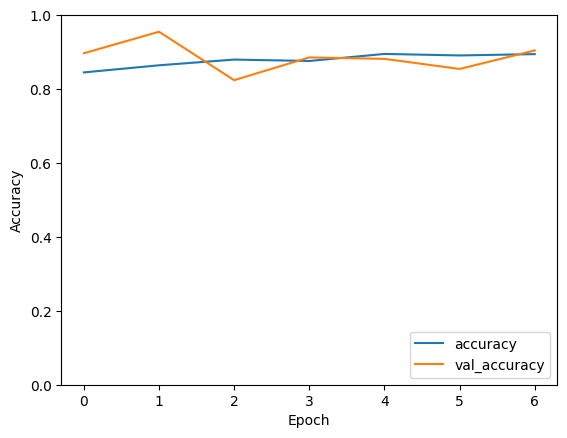

In [112]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

7/7 [==============================] - 0s 4ms/step
[[ 97   8]
 [ 11 100]]
Confusion matrix, without normalization
[[ 97   8]
 [ 11 100]]
accuracy:  0.9120370370370371


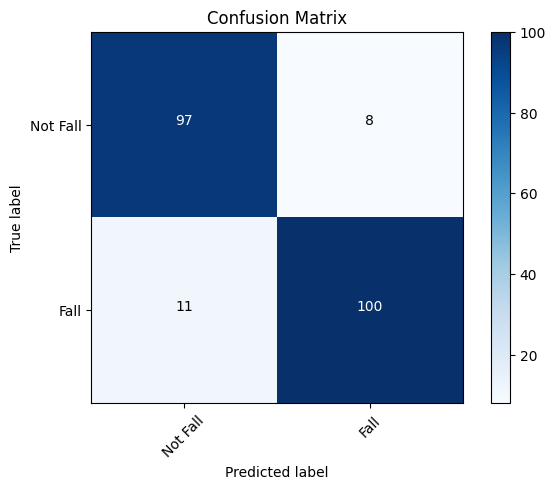

In [159]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(ResNet24.predict(X_test), axis=-1)


# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)

In [152]:
ResNet24.save('saved_models/ResNet24.keras')  # The file needs to end with the .keras extension
# convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(ResNet24)
ResNet24_tflite = converter.convert()
# save the model
open("saved_models/ResNet24.tflite", "wb").write(ResNet24_tflite)

INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp0gg2u2kp/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp0gg2u2kp/assets
2023-12-08 01:51:50.775316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-08 01:51:50.775458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-08 01:51:50.777933: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp0gg2u2kp
2023-12-08 01:51:50.788376: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-08 01:51:50.788393: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp0gg2u2kp
2023-12-08 01:51:50.822463: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-08 01:51:51.248440: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

231988

In [115]:
q_ResNet24 = tfmot.quantization.keras.quantize_model(ResNet24)
q_ResNet24.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_ResNet24.summary()

Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer_4 (Quantize  (None, 50, 9)                3         ['input_4[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape_3 (QuantizeW  (None, 1, 50, 9)             1         ['quantize_layer_4[0][0]']    
 rapperV2)                                                                                        
                                                                                           

In [116]:
q_history = q_ResNet24.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

Epoch 1/50
256/256 [==============================] - 13s 29ms/step - loss: 0.9134 - accuracy: 0.7950 - val_loss: 0.3259 - val_accuracy: 0.8533 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 8s 30ms/step - loss: 0.7345 - accuracy: 0.8355 - val_loss: 0.6014 - val_accuracy: 0.7697 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 8s 30ms/step - loss: 0.6371 - accuracy: 0.8651 - val_loss: 0.2597 - val_accuracy: 0.9113 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 8s 31ms/step - loss: 0.5623 - accuracy: 0.8798 - val_loss: 0.3060 - val_accuracy: 0.8814 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 8s 31ms/step - loss: 0.5235 - accuracy: 0.8839 - val_loss: 0.2986 - val_accuracy: 0.8942 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 8s 31ms/step - loss: 0.4174 - accuracy: 0.9061 - val_loss: 0.1939 - val_accuracy: 0.9259 - lr: 5.0000e-04
Epoch 7/50
256/256 [===================

In [117]:
q_ResNet24.save('q_ResNet24.keras')  # The file needs to end with the .keras extension


In [118]:
'''
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(q_ResNet24)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant_int8 = converter.convert()
'''

"\ndef representative_data_gen():\n  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):\n    yield [input_value]\n\nconverter = tf.lite.TFLiteConverter.from_keras_model(q_ResNet24)\nconverter.optimizations = [tf.lite.Optimize.DEFAULT]\nconverter.representative_dataset = representative_data_gen\nconverter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\nconverter._experimental_lower_tensor_list_ops = False\nconverter.inference_input_type = tf.int8\nconverter.inference_output_type = tf.int8\n\ntflite_model_quant_int8 = converter.convert()\n"

In [119]:
# convert the QAT model to a fully quantized model using TFLite

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(ResNet24)
converter.optimizations = [tf.lite.Optimize.DEFAULT]



# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_model_quant_int8_qat = converter.convert()


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpi8i_fp7f/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpi8i_fp7f/assets
/Users/liuxinqing/opt/anaconda3/envs/fall_detection/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-08 01:42:57.716011: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-08 01:42:57.716031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-08 01:42:57.716270: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpi8i_fp7f
2023-12-08 01:42:57.726514: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-08 01:42:57.726533: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v41

In [135]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8_qat)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open("saved_models/ResNet24_quant_int8_qat.tflite", "wb").write(tflite_model_quant_int8_qat)

input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


105616

In [144]:
# test the quantized model
X_test_int8 = X_test.astype('float32')
y_test_int8 = y_test.astype('int8')
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= tflite_model_quant_int8_qat)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_int8, axis=-1)



input:  {'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([ 1, 50,  9], dtype=int32), 'shape_signature': array([-1, 50,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 106, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
Evaluated on  200 .


TFLite Model size with 8-bit quantization: 103 KB
TFLite Model size without quantization: 226 KB

Reduction in model size by a factor of 2.196523
accuracy:  0.9120370370370371
Confusion matrix, without normalization
[[ 97   8]
 [ 11 100]]


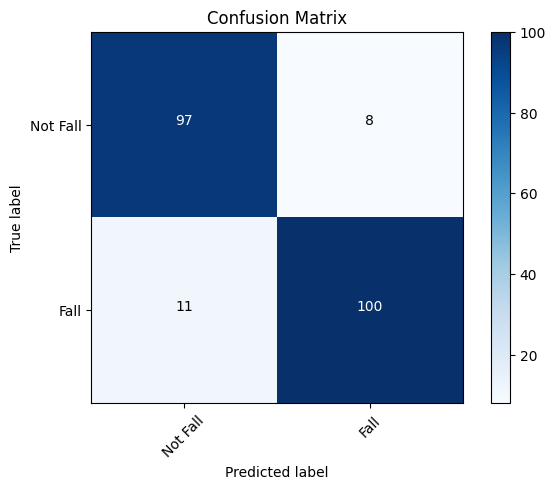

In [160]:
# Show the model size for the 8-bit quantized TFLite model
tflite_in_kb = os.path.getsize('saved_models/ResNet24.tflite') / 1024
# ResNet24_tflite tflite_quant_in_kb
tflite_quant_in_kb = os.path.getsize('saved_models/ResNet24_quant_int8_qat.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

print("TFLite Model size without quantization: %d KB" % tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (tflite_in_kb / tflite_quant_in_kb))

accuracy = (predictions == gt).mean()
print('accuracy: ', accuracy)
# compute the confusion matrix
cm = confusion_matrix(gt, predictions)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')



In [158]:
print('accuracy of full precision model: ', accuracy_fp)
print('accuracy of quantized model: ', accuracy)

accuracy of full precision model:  0.9120370370370371
accuracy of quantized model:  0.9120370370370371


# Pruning + QAT

In [174]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(ResNet24, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()

Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 prune_low_magnitude_reshap  (None, 1, 50, 9)             1         ['input_4[0][0]']             
 e_3 (PruneLowMagnitude)                                                                          
                                                                                                  
 prune_low_magnitude_conv2d  (None, 1, 48, 64)            3522      ['prune_low_magnitude_reshape_
 _81 (PruneLowMagnitude)                                            3[0][0]']                     
                                                                                           

In [175]:
pruned_model_unstructured.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, pruning_callbacks.UpdatePruningStep()],
            class_weight=class_weight) 

Epoch 1/50
256/256 [==============================] - 14s 24ms/step - loss: 0.4525 - accuracy: 0.9170 - val_loss: 0.2169 - val_accuracy: 0.9235 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 6s 23ms/step - loss: 0.3272 - accuracy: 0.9293 - val_loss: 0.3437 - val_accuracy: 0.8770 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 6s 22ms/step - loss: 0.3194 - accuracy: 0.9350 - val_loss: 0.6370 - val_accuracy: 0.8062 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 6s 23ms/step - loss: 0.4674 - accuracy: 0.9157 - val_loss: 0.1649 - val_accuracy: 0.9474 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 6s 23ms/step - loss: 0.3849 - accuracy: 0.9232 - val_loss: 0.2501 - val_accuracy: 0.9174 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 6s 25ms/step - loss: 0.3591 - accuracy: 0.9268 - val_loss: 0.2852 - val_accuracy: 0.9032 - lr: 5.0000e-04
Epoch 7/50
256/256 [===================

In [177]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(X_test, y_test, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', accuracy_fp)

Pruned model loss:  0.2559881806373596
Pruned model accuracy:  0.9351851940155029
Full-precision model accuracy:  0.9120370370370371


In [181]:
# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

# save the model
pruned_model_unstructured.save('saved_models/ResNet24_pruned_unstructured.keras')  # The file needs to end with the .keras extension
#print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

In [182]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = 'saved_models/ResNet24_pruned_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))

INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp77f5cbj3/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp77f5cbj3/assets


Saved pruned TFLite model to: /Users/liuxinqing/Documents/Fall_Detection/saved_models/ResNet24_pruned_unstructured.tflite


2023-12-08 02:17:15.845266: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-08 02:17:15.845433: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-08 02:17:15.846747: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp77f5cbj3
2023-12-08 02:17:15.853834: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-08 02:17:15.853846: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp77f5cbj3
2023-12-08 02:17:15.872969: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-08 02:17:16.035216: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp77f5cbj3
2023-12-

In [184]:
# Define a helper function to actually compress the models via gzip and measure the zipped size.
import tempfile

def get_gzipped_model_size(file):
    # It returns the size of the gzipped model in bytes.
    import os
    import zipfile
    
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)

In [187]:

# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured))
print('Size of the full-precision model: ', get_gzipped_model_size('saved_models/ResNet24.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('saved_models/ResNet24_pruned_unstructured.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured)))


Size of the unstructured pruned model:  128005
Size of the full-precision model:  201853
The achieved compression ratio is 1.00x


In [197]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

pruned_qat_model.summary()

Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer_6 (Quantize  (None, 50, 9)                3         ['input_4[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape_3 (QuantizeW  (None, 1, 50, 9)             1         ['quantize_layer_6[0][0]']    
 rapperV2)                                                                                        
                                                                                           

In [198]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
print('X_train.shape: ', X_train.shape) # (16362, 50, 9)
print('y_train.shape: ', y_train.shape) # (16362, 2)
print(batch_size)
pruned_qat_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, pruning_callbacks.UpdatePruningStep()],
            class_weight=class_weight) 


X_train.shape:  (16362, 50, 9)
y_train.shape:  (16362, 2)
64
Epoch 1/50
256/256 [==============================] - 11s 29ms/step - loss: 1.0197 - accuracy: 0.8261 - val_loss: 0.1878 - val_accuracy: 0.9186 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 7s 29ms/step - loss: 0.5408 - accuracy: 0.8902 - val_loss: 0.2299 - val_accuracy: 0.9181 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 7s 29ms/step - loss: 0.4254 - accuracy: 0.9095 - val_loss: 0.1578 - val_accuracy: 0.9440 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 8s 30ms/step - loss: 0.3731 - accuracy: 0.9229 - val_loss: 0.2064 - val_accuracy: 0.9291 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 8s 30ms/step - loss: 0.2628 - accuracy: 0.9400 - val_loss: 0.1617 - val_accuracy: 0.9477 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 8s 29ms/step - loss: 0.2337 - accuracy: 0.9487 - val_loss: 0.1670 - val_accuracy: 0.

In [199]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(X_test, y_test, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', accuracy_fp)

Pruned QAT model loss:  0.22265245020389557
Pruned QAT model accuracy:  0.9351851940155029
Full-precision model accuracy:  0.9120370370370371


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
pruned_qat_tflite_file = 'models/pruned_qat_model.tflite'

with open(pruned_qat_tflite_file, 'wb') as f:
    f.write(pruned_qat_tflite_model)

print('Saved pruned QAT TFLite model to:', os.path.abspath(pruned_qat_tflite_file))

# write TFLite model to a C source (or header) file
#c_model_name = 'pruned_qat_fmnist'

#with open('cfiles/' + c_model_name + '.h', 'w') as file:
#    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))

# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size(pruned_qat_tflite_file))
print('Size of th QAT model: ', get_gzipped_model_size( 'models/fmnist_qat_int8.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_qat_tflite_file)))